# Multi-period OPF example

In [28]:
import os
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nygrid.run_nygrid import NYGrid


In [29]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: /home/by276/models/NYgrid-python/data/grid
Figure directory: /home/by276/models/NYgrid-python/figures
Results directory: /home/by276/models/NYgrid-python/results


## Read grid data

In [30]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2018, 1, 5, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'


# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmax_profile.index.freq = 'H'

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmin_profile.index.freq = 'H'

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genramp30_profile.index.freq = 'H'

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost0_profile.index.freq = 'H'

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost1_profile.index.freq = 'H'


## Multi-period OPF

### Without initial conditions

In [31]:
# Only run for one day
d = 0
start_datetime = timestamp_list[d]
end_datetime = timestamp_list[d+1]
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-01 00:00:00
End time: 2018-01-02 00:00:00


In [32]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%Y-%m-%d'), 
                    end_datetime=end_datetime.strftime('%Y-%m-%d'), 
                    verbose=True)

# Read grid data
nygrid_sim.get_load_data(load_profile)
nygrid_sim.get_gen_data(gen_profile)
nygrid_sim.get_genmax_data(genmax_profile)
nygrid_sim.get_genmin_data(genmin_profile)
nygrid_sim.get_genramp_data(genramp30_profile)
nygrid_sim.get_gencost_data(gencost0_profile, gencost1_profile)

# Process ppc
nygrid_sim.process_ppc()

# Set generator initial condition
nygrid_sim.get_gen_init_data(gen_init=None)

# Check input
nygrid_sim.check_input_dim()

Initializing NYGrid run...
NYGrid run starting on: 2018-01-01 00:00:00
NYGrid run ending on: 2018-01-02 00:00:00
NYGrid run duration: 1 day, 0:00:00


In [33]:
# Initialize single period OPF
model_multi_opf_0 = nygrid_sim.create_multi_opf()
nygrid_sim.show_model_dim(model_multi_opf_0)

[    0.00] Starting timer ...
[+   1.13] Created constraints for time step 0 ...
[+   1.10] Created constraints for time step 1 ...
[+   1.11] Created constraints for time step 2 ...
[+   1.11] Created constraints for time step 3 ...
[+   1.09] Created constraints for time step 4 ...
[+   1.09] Created constraints for time step 5 ...
[+   1.09] Created constraints for time step 6 ...
[+   1.10] Created constraints for time step 7 ...
[+   1.10] Created constraints for time step 8 ...
[+   1.10] Created constraints for time step 9 ...
[+   1.10] Created constraints for time step 10 ...
[+   1.10] Created constraints for time step 11 ...
[+   1.10] Created constraints for time step 12 ...
[+   1.10] Created constraints for time step 13 ...
[+   1.24] Created constraints for time step 14 ...
[+   1.09] Created constraints for time step 15 ...
[+   1.09] Created constraints for time step 16 ...
[+   1.09] Created constraints for time step 17 ...
[+   1.09] Created constraints for time step

In [34]:
solver = SolverFactory('glpk')

results_multi_opf = solver.solve(model_multi_opf_0, tee=True)

if nygrid_sim.check_status(results_multi_opf):
     print('%.2f' % model_multi_opf_0.obj())

# Get results
results_0 = nygrid_sim.get_results_multi_opf(model_multi_opf_0)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpachn33p7.glpk.raw --wglp /tmp/tmpvzmky9de.glpk.glp --cpxlp
 /tmp/tmpmc42f0d0.pyomo.lp
Reading problem data from '/tmp/tmpmc42f0d0.pyomo.lp'...
36468 rows, 10751 columns, 67035 non-zeros
193973 lines were read
Writing problem data to '/tmp/tmpvzmky9de.glpk.glp'...
165801 lines were written
GLPK Simplex Optimizer 5.0
36468 rows, 10751 columns, 67035 non-zeros
Preprocessing...
6331 rows, 8425 columns, 23237 non-zeros
Scaling...
 A: min|aij| =  1.061e-01  max|aij| =  5.058e+02  ratio =  4.766e+03
GM: min|aij| =  4.212e-02  max|aij| =  2.374e+01  ratio =  5.636e+02
EQ: min|aij| =  1.774e-03  max|aij| =  1.000e+00  ratio =  5.636e+02
Constructing initial basis...
Size of triangular part is 6281
      0: obj =   1.522599086e+08 inf =   2.697e+03 (1154)
   6625: obj =   1.498069747e+08 inf =   1.564e-14 (0) 36
* 12080: obj =   1.183645371e+08 inf =   0.000e+00 (0) 27
OPTIMAL LP SOLUTION FOUND
Time used:

### With initial conditions

In [35]:
# Only run for one day
d = 1
start_datetime = timestamp_list[d]
end_datetime = timestamp_list[d+1]
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-01-02 00:00:00
End time: 2018-01-03 00:00:00


In [36]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%Y-%m-%d'), 
                    end_datetime=end_datetime.strftime('%Y-%m-%d'), 
                    verbose=True)

# Read grid data
nygrid_sim.get_load_data(load_profile)
nygrid_sim.get_gen_data(gen_profile)
nygrid_sim.get_genmax_data(genmax_profile)
nygrid_sim.get_genmin_data(genmin_profile)
nygrid_sim.get_genramp_data(genramp30_profile)
nygrid_sim.get_gencost_data(gencost0_profile, gencost1_profile)

# Process ppc
nygrid_sim.process_ppc()

# Set generator initial condition
last_gen = nygrid_sim.get_last_gen(model_multi_opf_0)
nygrid_sim.get_gen_init_data(gen_init=last_gen)

# Check input
nygrid_sim.check_input_dim()

Initializing NYGrid run...
NYGrid run starting on: 2018-01-02 00:00:00
NYGrid run ending on: 2018-01-03 00:00:00
NYGrid run duration: 1 day, 0:00:00


In [37]:
# Initialize single period OPF
model_multi_opf_1 = nygrid_sim.create_multi_opf()
nygrid_sim.show_model_dim(model_multi_opf_1)

[    0.00] Starting timer ...
[+   1.10] Created constraints for time step 0 ...
[+   1.09] Created constraints for time step 1 ...
[+   1.10] Created constraints for time step 2 ...
[+   1.30] Created constraints for time step 3 ...
[+   1.10] Created constraints for time step 4 ...
[+   1.09] Created constraints for time step 5 ...
[+   1.09] Created constraints for time step 6 ...
[+   1.10] Created constraints for time step 7 ...
[+   1.09] Created constraints for time step 8 ...
[+   1.10] Created constraints for time step 9 ...
[+   1.10] Created constraints for time step 10 ...
[+   1.09] Created constraints for time step 11 ...
[+   1.09] Created constraints for time step 12 ...
[+   1.09] Created constraints for time step 13 ...
[+   1.09] Created constraints for time step 14 ...
[+   1.09] Created constraints for time step 15 ...
[+   1.09] Created constraints for time step 16 ...
[+   1.09] Created constraints for time step 17 ...
[+   1.10] Created constraints for time step

In [38]:
solver = SolverFactory('glpk')

results_multi_opf = solver.solve(model_multi_opf_1, tee=True)

if nygrid_sim.check_status(results_multi_opf):
     print('%.2f' % model_multi_opf_1.obj())

# Get results
results_1 = nygrid_sim.get_results_multi_opf(model_multi_opf_1)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp2n9xsjyr.glpk.raw --wglp /tmp/tmpeuhuk4wp.glpk.glp --cpxlp
 /tmp/tmpjjnpkjvr.pyomo.lp
Reading problem data from '/tmp/tmpjjnpkjvr.pyomo.lp'...
37026 rows, 10751 columns, 67593 non-zeros
196205 lines were read
Writing problem data to '/tmp/tmpeuhuk4wp.glpk.glp'...
167475 lines were written
GLPK Simplex Optimizer 5.0
37026 rows, 10751 columns, 67593 non-zeros
Preprocessing...
6251 rows, 8400 columns, 23052 non-zeros
Scaling...
 A: min|aij| =  1.061e-01  max|aij| =  5.058e+02  ratio =  4.766e+03
GM: min|aij| =  4.212e-02  max|aij| =  2.374e+01  ratio =  5.636e+02
EQ: min|aij| =  1.774e-03  max|aij| =  1.000e+00  ratio =  5.636e+02
Constructing initial basis...
Size of triangular part is 6201
      0: obj =   1.631707647e+08 inf =   2.813e+03 (1168)
   6576: obj =   1.569488709e+08 inf =   4.108e-13 (0) 33
* 11575: obj =   1.282331974e+08 inf =   4.441e-16 (0) 23
OPTIMAL LP SOLUTION FOUND
Time used:

## Process the results

In [43]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [44]:
# Format results
results_pg_0 = results_0['PG']
thermal_pg_0 = results_pg_0.iloc[:, :num_thermal]
thermal_pg_0 = thermal_pg_0.rename(columns=gen_rename)
print(thermal_pg_0.head())

results_pg_1 = results_1['PG']
thermal_pg_1 = results_pg_1.iloc[:, :num_thermal]
thermal_pg_1 = thermal_pg_1.rename(columns=gen_rename)
print(thermal_pg_1.head())

                     59 St.  GT 1  74 St.  GT 1  74 St.  GT 2  Allegany  \
2018-01-01 00:00:00           0.0           0.0           0.0      66.0   
2018-01-01 01:00:00           0.0           0.0           0.0      66.0   
2018-01-01 02:00:00           0.0           0.0           0.0      66.0   
2018-01-01 03:00:00           0.0           0.0           0.0      66.0   
2018-01-01 04:00:00           0.0           0.0           0.0      66.0   

                     Allied Frozen Storage  Arthur Kill Cogen  \
2018-01-01 00:00:00                    0.1               11.1   
2018-01-01 01:00:00                    0.1               11.1   
2018-01-01 02:00:00                    0.1               11.1   
2018-01-01 03:00:00                    0.1               11.1   
2018-01-01 04:00:00                    0.1               11.1   

                     Arthur Kill GT 1  Arthur Kill ST 2  Arthur Kill ST 3  \
2018-01-01 00:00:00              20.0             349.0             539.0   
2018

In [49]:
def plot_gen(ax, thermal_pg, ii, title=None):

    ax.plot(thermal_pg.index, thermal_pg.iloc[:, ii], marker='*', label='OPF')
    ax.plot(thermal_pg.index, nygrid_sim.gen_profile[:, ii], marker='o', label='historical')
    ax.plot(thermal_pg.index, nygrid_sim.genmax_profile[:, ii], linestyle='--', label='max')
    ax.plot(thermal_pg.index, nygrid_sim.genmin_profile[:, ii], linestyle='--', label='min')
    ax.legend()
    ax.set_title(title)

    return ax

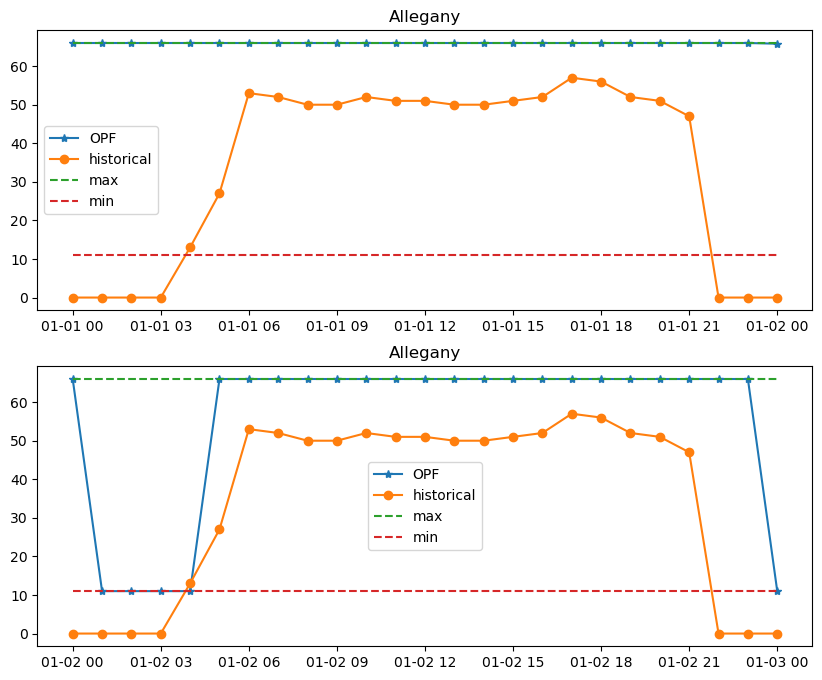

In [50]:
ii = 3
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1 = plot_gen(ax=ax1, thermal_pg=thermal_pg_0, ii=ii, title=gen_info.NYISOName[ii])
ax2 = plot_gen(ax=ax2, thermal_pg=thermal_pg_1, ii=ii, title=gen_info.NYISOName[ii])

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object


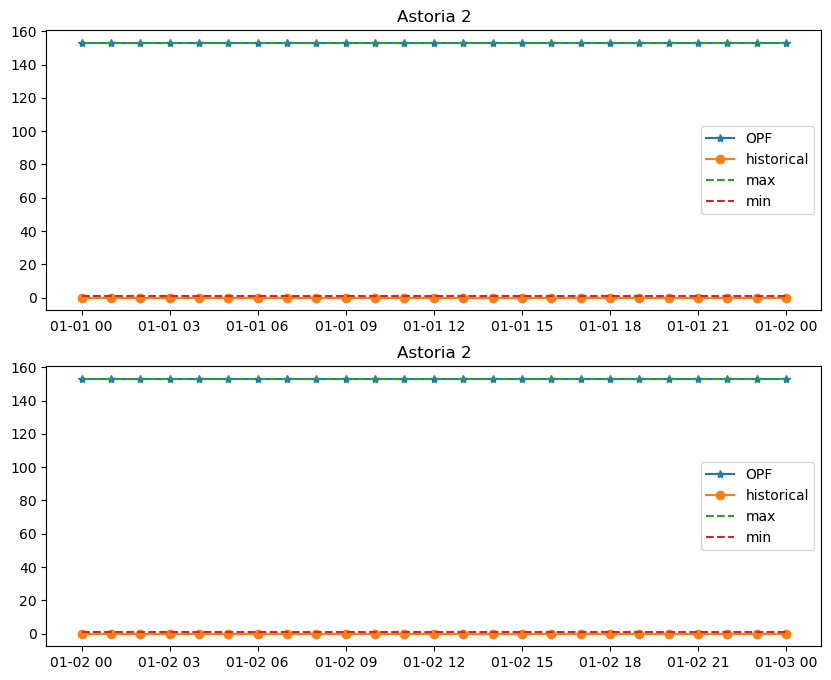

In [55]:
ii = 9
print(gen_info.iloc[ii, :])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1 = plot_gen(ax=ax1, thermal_pg=thermal_pg_0, ii=ii, title=gen_info.NYISOName[ii])
ax2 = plot_gen(ax=ax2, thermal_pg=thermal_pg_1, ii=ii, title=gen_info.NYISOName[ii])

NYISOName           EMPIRE_CC_2
PTID                     323658
Zone                          F
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.6296
Longitude               -73.749
maxPower                  327.0
minPower                  159.0
maxRampAgc                3.125
maxRamp10                 31.25
maxRamp30                 93.75
maxRamp60                 187.5
HeatRateLM_1           6.613482
HeatRateLM_0          112.15103
HeatRateLM_R2           0.97822
HeatRateQM_2           0.008103
HeatRateQM_1           2.913671
HeatRateQM_0         520.066758
HeatRateQM_R2          0.980529
useQM                         1
start-time                  12h
Name: 83, dtype: object


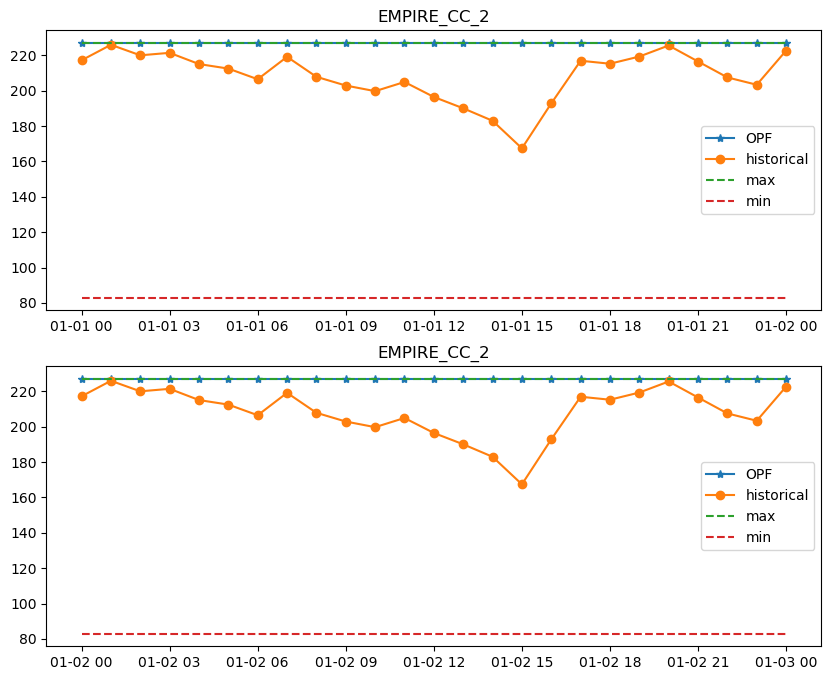

In [56]:
ii = 83
print(gen_info.iloc[ii, :])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1 = plot_gen(ax=ax1, thermal_pg=thermal_pg_0, ii=ii, title=gen_info.NYISOName[ii])
ax2 = plot_gen(ax=ax2, thermal_pg=thermal_pg_1, ii=ii, title=gen_info.NYISOName[ii])